In [42]:
tsv <- file.path("/data", "samples", "AIRR-Seq", "OURS", "S3987Nr1", "S3987Nr1-PBMC_heavy", "changeo_igblast", "S3987Nr1-PBMC_heavy_f_parse-select_with_translation.tsv")# "clones", "changeo_clone",  "our_pbmc_germ-pass.tsv")

In [135]:
include = function(pkg){
  if(!suppressMessages(require(pkg, character.only = TRUE)))
  install.packages(pkg, character.only = TRUE)
  suppressMessages(library(pkg, pkg, character.only = TRUE))
}
include("docopt")
include("stringr")
include("alakazam")
include("scoper")
include("dplyr")

In [163]:
doc <- 'Usage:
  clones.R [--name <name>] [--wd <wd>][--suffix <suffix>] <tsv> 

  Options:   
   -w --wd <wd> [default: TRUE]
   -n --name <name>
   -s --suffix <suffix> [default: _with_clones].
   -h --help     Show this screen.'

In [170]:
debug <- TRUE
if(debug == TRUE) {
    tsv <- file.path("/data", "samples", "AIRR-Seq", "OURS", "S3987Nr1", "S3987Nr1-PBMC_heavy", "changeo_igblast", "S3987Nr1-PBMC_heavy_f_parse-select_with_translation.tsv")# "clones", "changeo_clone",  "our_pbmc_germ-pass.tsv")    
    args <- paste("--suffix _with_clones --name S3987Nr1-PBMC_heavy", tsv)
    print(args)
    values <- docopt(doc, args = args, version="0.1")
} else {
    values <- docopt(doc, version="0.1")
}


[1] "--suffix _with_clones --name S3987Nr1-PBMC_heavy /data/samples/AIRR-Seq/OURS/S3987Nr1/S3987Nr1-PBMC_heavy/changeo_igblast/S3987Nr1-PBMC_heavy_f_parse-select_with_translation.tsv"


In [172]:
tsv <- values$tsv
name <- values$name
name

[1] "S3987Nr1-PBMC_heavy"

In [136]:
db = readChangeoDb(tsv)
# Clonal assignment using identical nucleotide sequences
results <- spectralClones(db, "vj")

Running defineClonesScoper in bulk mode



In [177]:
wd = getwd()
write.table(results@vjl_groups, file=file.path(paste0(name,"_vjl_groups",'.tsv')), quote=FALSE, row.names = FALSE, sep='\t')


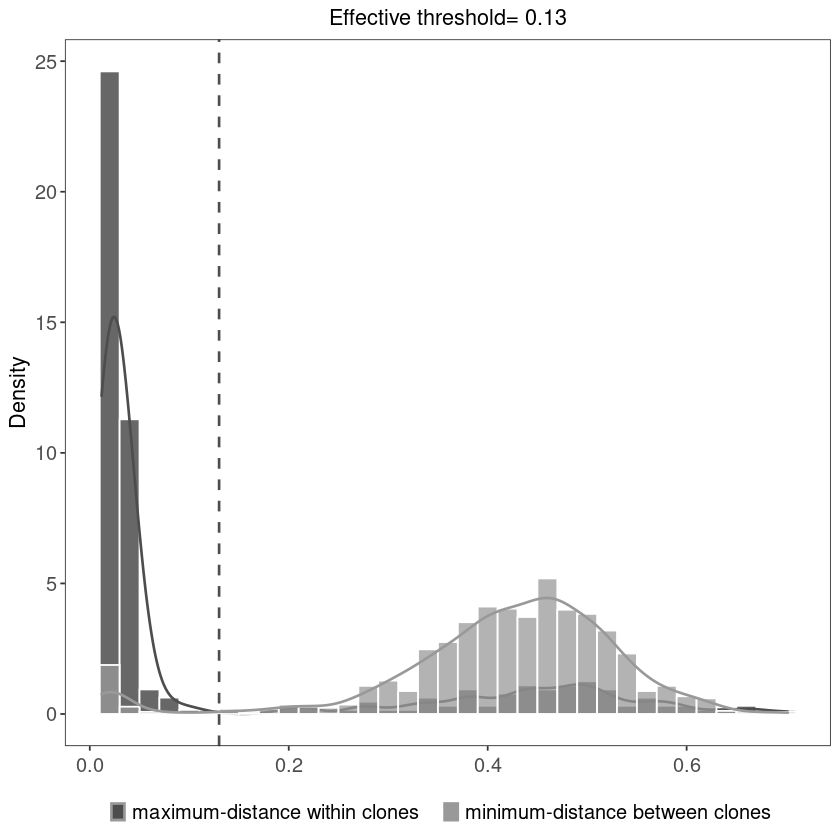

In [53]:
png(file=paste0(name+values$suffix".png"), width = 800, height = 600)
plot(results, binwidth=0.02)
dev.off()